In [86]:
import sys
sys.path.append('../')

%reload_ext autoreload
%autoreload 2

import Utility as ut
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import scipy

from matplotlib.lines import Line2D

from collections import Counter

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import RegressorChain

np.random.seed(0)

In [87]:
cycleA = pd.read_csv("../Data/Chickens data/WithMacro/CycleA-Clean.csv")
cycleB = pd.read_csv("../Data/Chickens data/WithMacro/CycleB-Clean.csv")
cycleC = pd.read_csv("../Data/Chickens data/WithMacro/CycleC-Clean.csv")

In [88]:
cycleA=cycleA.rename(columns={"Date of Laid": "Date"})
cycleA.Date = pd.to_datetime(cycleA.Date, format = '%m/%d/%Y')
cycleB=cycleB.rename(columns={"Date of Laid": "Date"})
cycleB.Date = pd.to_datetime(cycleB.Date, format = '%m/%d/%Y')
cycleC=cycleC.rename(columns={"Date of Laid": "Date"})
cycleC.Date = pd.to_datetime(cycleC.Date, format = '%m/%d/%Y')



cycleA=cycleA.rename(columns={"Laied": "Laid"})
cycleB=cycleB.rename(columns={"Laied": "Laid"})
cycleC=cycleC.rename(columns={"Laied": "Laid"})

In [89]:

list(cycleA.columns.drop(["Date","DeathPerc"]))

['Arrival Chickens Date',
 'Death',
 'Chickens',
 'Eggs',
 'Laid',
 'Water',
 'Feed',
 'Date of Selling',
 '# Eggs sold (First quality)',
 '# Eggs sold (Second quality)',
 'AvgTemp',
 'MinTemp',
 'MaxTemp',
 'AvgHum',
 'MinHum',
 'MaxHum']

In [90]:
cycleA = cycleA.drop(columns=list(cycleA.columns.drop(["Date","DeathPerc"])))
cycleB = cycleB.drop(columns=list(cycleB.columns.drop(["Date","DeathPerc"])))
cycleC = cycleC.drop(columns=list(cycleC.columns.drop(["Date","DeathPerc"])))

In [91]:
cycleA = cycleA.set_index("Date")
cycleB = cycleB.set_index("Date")
cycleC = cycleC.set_index("Date")


In [92]:
def window_input_output(input_length: int, output_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df = data.copy()
    
    i = 1
    while i < input_length:
        df[f'x_{i}'] = df['DeathPerc'].shift(-i)
        i = i + 1
        
    j = 0
    while j < output_length:
        df[f'y_{j}'] = df['DeathPerc'].shift(-input_length-j)
        j = j + 1
        
    df = df.dropna(axis=0)
    
    return df

In [93]:
input_dim = 100
output_dim = 300

In [94]:
cycles = pd.concat([cycleA,cycleB], axis=0)

In [95]:
cycles

,DeathPerc
Date,
2018-09-01,0.000238
2018-09-02,0.000262
2018-09-03,0.000262
2018-09-04,0.000191
2018-09-05,0.000262
...,...
2022-04-28,0.000538
2022-04-29,0.000570
2022-04-30,0.000602


In [96]:
seq_df = window_input_output(input_dim, output_dim, cycles)

C:\Users\canal\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if sys.path[0] == "":


In [97]:
X_cols = [col for col in seq_df.columns if col.startswith('x')]

In [98]:
X_cols = [col for col in seq_df.columns if col.startswith('x')]

X_cols.insert(0, 'DeathPerc')

y_cols = [col for col in seq_df.columns if col.startswith('y')]
X_train = seq_df[X_cols][2:].values
y_train = seq_df[y_cols][2:].values

X_test = seq_df[X_cols][:2].values
y_test = seq_df[y_cols][:2 ].values

In [99]:
gbr_seq = GradientBoostingRegressor(random_state=42)

chained_gbr = RegressorChain(gbr_seq)

chained_gbr.fit(X_train, y_train)

gbr_seq_preds = chained_gbr.predict(X_test)

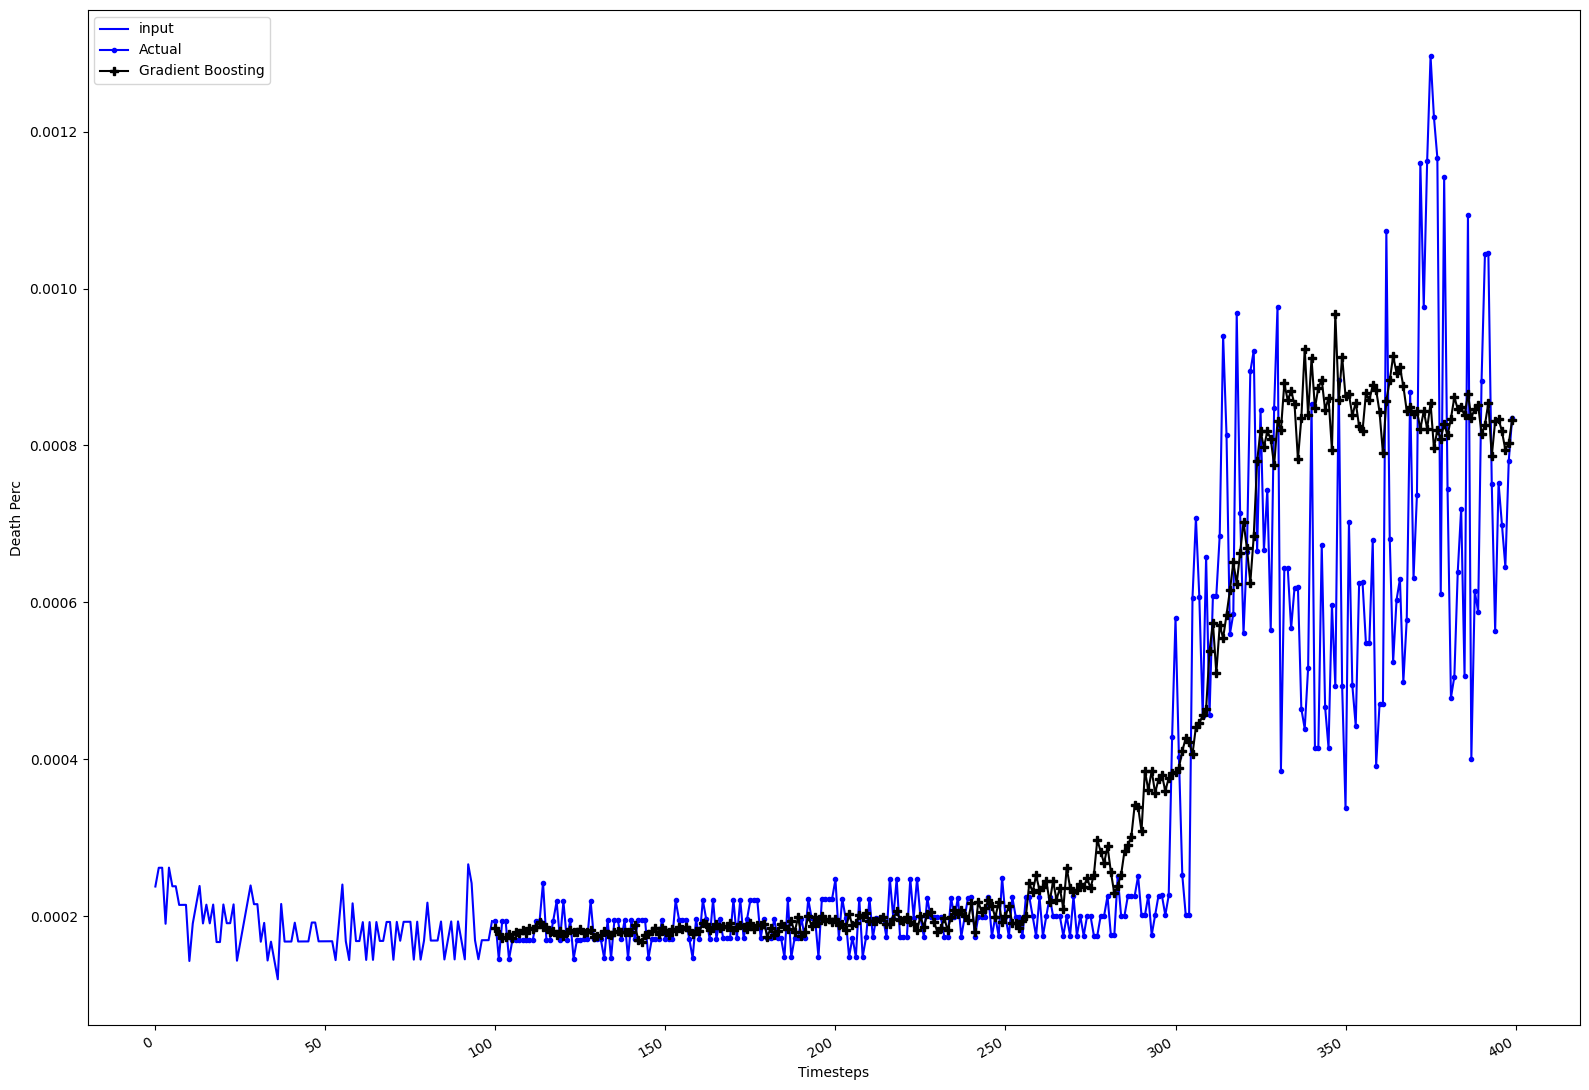

In [100]:
fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(np.arange(0, input_dim, 1), X_test[0], 'b-', label='input')
ax.plot(np.arange(input_dim, input_dim+output_dim, 1), y_test[0], marker='.', color='blue', label='Actual')
ax.plot(np.arange(input_dim, input_dim+output_dim, 1), gbr_seq_preds[0], marker='P', color='black', label='Gradient Boosting')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Death Perc')

plt.legend(loc=2)
fig.autofmt_xdate()
plt.tight_layout()

In [101]:
seq_df_c = window_input_output(input_dim, 0, cycleC)

In [102]:
X_cols = [col for col in seq_df_c.columns if col.startswith('x')]

X_cols.insert(0, 'DeathPerc')

y_cols = [col for col in seq_df_c.columns if col.startswith('y')]
X = seq_df_c[X_cols].values

In [103]:
gbr_seq_preds_C = chained_gbr.predict(X)

In [110]:
X[0]

array([0.00038925, 0.00019464, 0.00019466, 0.00019468, 0.00021904,
       0.00017038, 0.00041391, 0.00026787, 0.00034101, 0.00021924,
       0.00024364, 0.00017056, 0.00024369, 0.00019497, 0.00014624,
       0.00012187, 0.00014625, 0.00012188, 0.00019502, 0.0002682 ,
       0.00026825, 0.00019511, 0.00021952, 0.00021955, 0.00021958,
       0.00017079, 0.00019521, 0.00017082, 0.00017084, 0.00024409,
       0.00019529, 0.00021973, 0.00017091, 0.00017092, 0.00019536,
       0.00048859, 0.00048878, 0.00056236, 0.00053815, 0.00048942,
       0.00056309, 0.00058786, 0.00046556, 0.00044121, 0.00051496,
       0.00053972, 0.00053996, 0.00056476, 0.00051587, 0.00056526,
       0.00049173, 0.00056575, 0.00049215, 0.00049234, 0.00051718,
       0.0005667 , 0.00044366, 0.00056716, 0.00054274, 0.0004936 ,
       0.00051849, 0.00051871, 0.00049421, 0.0004944 , 0.0004946 ,
       0.00049479, 0.00061881, 0.00052002, 0.00047067, 0.00054523,
       0.00049586, 0.00057051, 0.00054595, 0.00049651, 0.00052

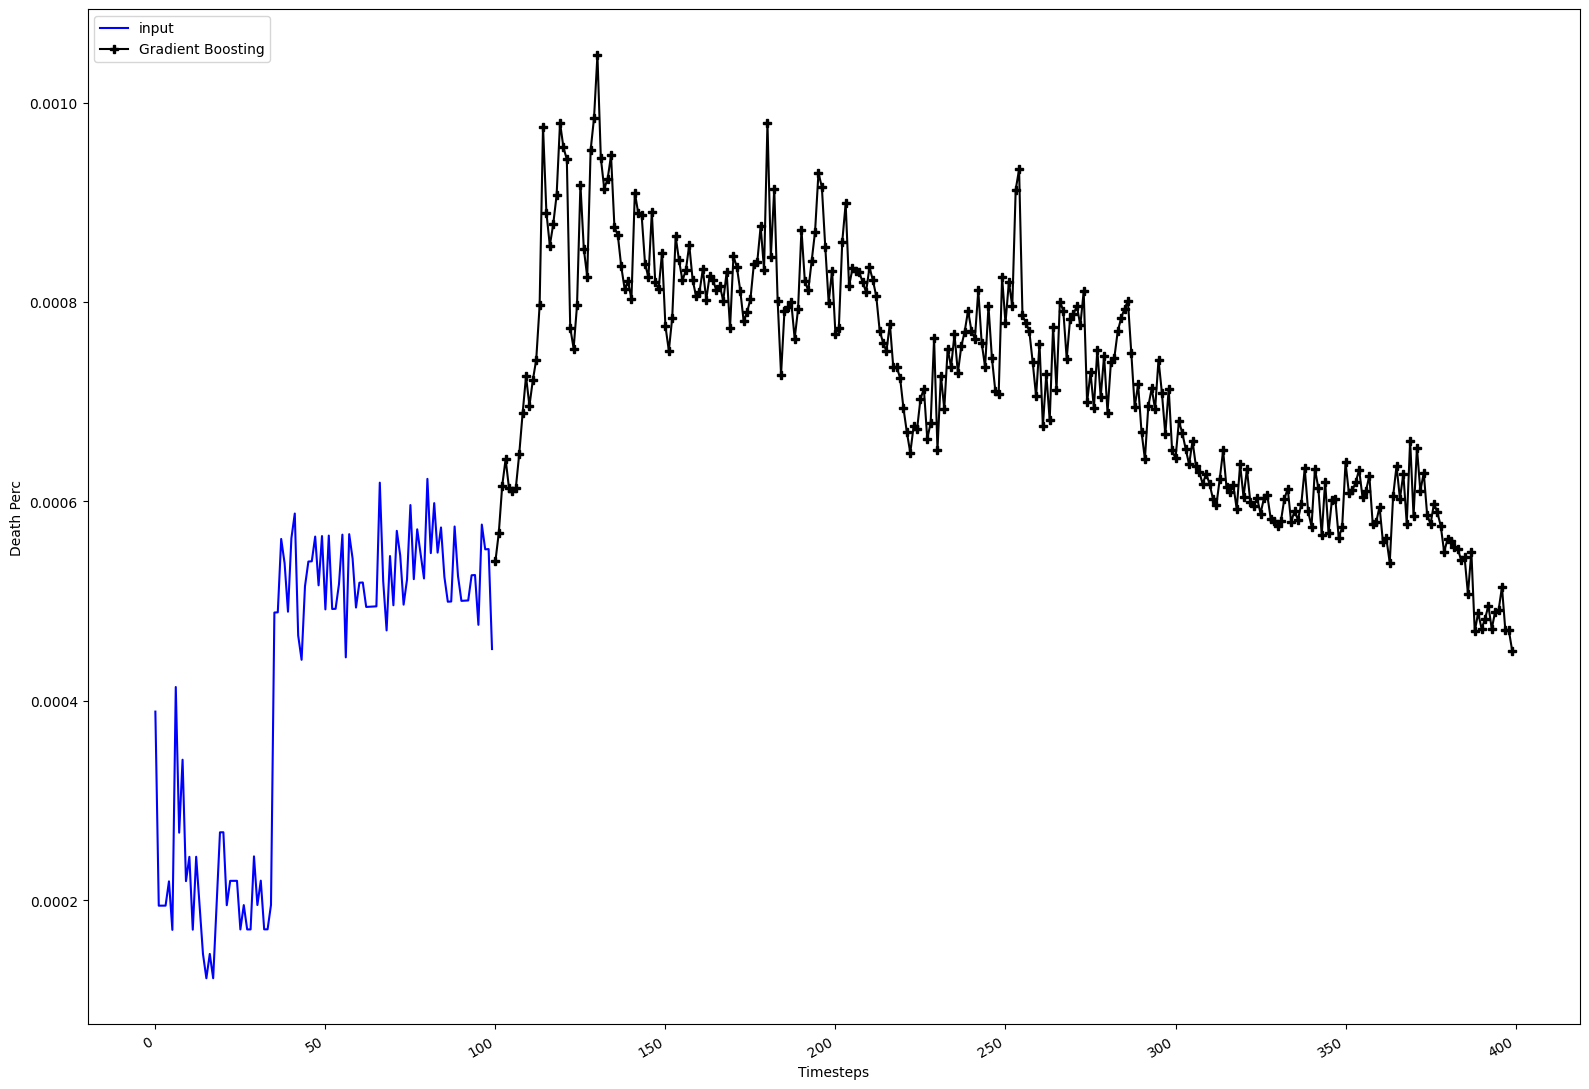

In [104]:
fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(np.arange(0, input_dim, 1), X[0], 'b-', label='input')
ax.plot(np.arange(input_dim, input_dim+300, 1), gbr_seq_preds_C[0], marker='P', color='black', label='Gradient Boosting')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Death Perc')

plt.legend(loc=2)
fig.autofmt_xdate()
plt.tight_layout()

In [109]:
np.savetxt("pred.txt", gbr_seq_preds_C[0], delimiter=",")

In [105]:
gbr_seq_preds_C[0]

array([0.00054007, 0.00056869, 0.00061589, 0.00064238, 0.00061323,
       0.00060996, 0.00061337, 0.00064753, 0.00068833, 0.00072553,
       0.00069589, 0.00072146, 0.00074212, 0.00079662, 0.00097595,
       0.00088944, 0.0008565 , 0.000878  , 0.00090727, 0.00097975,
       0.00095503, 0.00094297, 0.00077426, 0.00075333, 0.0007967 ,
       0.00091772, 0.00085319, 0.00082516, 0.00095231, 0.00098446,
       0.00104749, 0.00094438, 0.00091366, 0.00092341, 0.00094692,
       0.00087523, 0.00086688, 0.00083568, 0.00081317, 0.00082062,
       0.00080287, 0.00090976, 0.00088902, 0.00088715, 0.00083841,
       0.00082456, 0.00089011, 0.00081971, 0.00081291, 0.00084956,
       0.00077565, 0.00075117, 0.00078436, 0.00086576, 0.0008416 ,
       0.00082169, 0.00083173, 0.0008574 , 0.00082212, 0.00080585,
       0.00080981, 0.00083289, 0.00080234, 0.00082631, 0.00082155,
       0.00081154, 0.00081613, 0.00080118, 0.00082984, 0.00077415,
       0.00084579, 0.00083516, 0.00081144, 0.00078092, 0.00078